#  **PH 551-001-Machine Learning: Final Group Project**

## **Streamflow prediction using Long Short-Term Memory (LSTM) Network**

#### *Group 20: Ali Takallou, Habtamu Tamiru, Nischal Karki*


# **Import Libraries**

# 1) Data Download, Explore and Prepare
Start by downloading CAMELS data, loading into notebook and exploring attributes in this format:

| Basin_ID | Date | Precip | Climate | Vegetation | Topography | Soil | Geology | Streamflow |
|----------|----------|----------|----------|----------|----------|----------|----------|----------|

In [36]:
import os
import pandas as pd
import glob
import shutil
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path
import random
import warnings
import joblib
from typing import TYPE_CHECKING, Any, Union
import geopandas as gpd
from pathlib import Path

In [37]:
os.chdir('/mh1/Atakallou/MLproject')

In [38]:
def import_attributes(folder, attr_subset=None, return_list=False):
    attr_files = glob.glob(os.path.join(folder, 'camels_*.txt'))
    print(f"Found files: {attr_files}")

    if not attr_files:
        print("No files found. Check the folder path or file pattern.")
        return [] if return_list else pd.DataFrame()

    if attr_subset is not None:
        new_list = []
        for file in attr_files:
            attr = os.path.basename(file).split('_')[1]
            if attr in attr_subset:
                new_list.append(file)
        if not new_list:
            raise ValueError('attrSubset contained no valid attribute names')
        attr_files = new_list

    basin_attr = None
    basin_list = []
    for afile in attr_files:
        rfile = pd.read_csv(afile, sep=';')
        if 'gauge_id' not in rfile.columns:
            print(f"'gauge_id' column not found in {afile}.")
        else:
            rfile.set_index('gauge_id', inplace=True)


        if basin_attr is None:
            basin_attr = rfile
        else:
            try:
                basin_attr = basin_attr.merge(rfile, left_index=True, right_index=True)
            except Exception as e:
                print(f"Unable to merge {afile} based on 'gauge_id'. Error: {e}")

        if return_list:
            basin_list.append(rfile)

    if return_list:
        return basin_list
    else:
        return basin_attr

camels_dir = '/mh1/Atakallou/MLproject'
CAMELS_LongTerm_All = import_attributes(camels_dir)
CAMELS_LongTerm_All = pd.DataFrame(CAMELS_LongTerm_All)
CAMELS_LongTerm_All = CAMELS_LongTerm_All.reset_index()
CAMELS_LongTerm_All.head(4)

Found files: ['/mh1/Atakallou/MLproject/camels_clim.txt', '/mh1/Atakallou/MLproject/camels_geol.txt', '/mh1/Atakallou/MLproject/camels_hydro.txt', '/mh1/Atakallou/MLproject/camels_name.txt', '/mh1/Atakallou/MLproject/camels_soil.txt', '/mh1/Atakallou/MLproject/camels_topo.txt', '/mh1/Atakallou/MLproject/camels_vege.txt']


,gauge_id,p_mean,pet_mean,p_seasonality,frac_snow,aridity,high_prec_freq,high_prec_dur,high_prec_timing,low_prec_freq,...,area_geospa_fabric,frac_forest,lai_max,lai_diff,gvf_max,gvf_diff,dom_land_cover_frac,dom_land_cover,root_depth_50,root_depth_99
0,1013500,3.126679,1.971555,0.187940,0.313440,0.630559,12.95,1.348958,son,202.20,...,2303.95,0.9063,4.167304,3.340732,0.804567,0.371648,0.883452,Mixed Forests,NaN,NaN
1,1022500,3.608126,2.119256,-0.114530,0.245259,0.587356,20.55,1.205279,son,233.65,...,620.38,0.9232,4.871392,3.746692,0.863936,0.337712,0.820493,Mixed Forests,0.237435,2.238444
2,1030500,3.274405,2.043594,0.047358,0.277018,0.624111,17.15,1.207746,son,215.60,...,3676.09,0.8782,4.685200,3.665543,0.858502,0.351393,0.975258,Mixed Forests,NaN,NaN
3,1031500,3.522957,2.071324,0.104091,0.291836,0.587950,18.90,1.148936,son,227.35,...,766.53,0.9548,4.903259,3.990843,0.870668,0.398619,1.000000,Mixed Forests,0.250000,2.400000


### ***Explore***:

In [39]:
CAMELS_LongTerm_All.columns

Index(['gauge_id', 'p_mean', 'pet_mean', 'p_seasonality', 'frac_snow',
       'aridity', 'high_prec_freq', 'high_prec_dur', 'high_prec_timing',
       'low_prec_freq', 'low_prec_dur', 'low_prec_timing', 'geol_1st_class',
       'glim_1st_class_frac', 'geol_2nd_class', 'glim_2nd_class_frac',
       'carbonate_rocks_frac', 'geol_porostiy', 'geol_permeability', 'q_mean',
       'runoff_ratio', 'slope_fdc', 'baseflow_index', 'stream_elas', 'q5',
       'q95', 'high_q_freq', 'high_q_dur', 'low_q_freq', 'low_q_dur',
       'zero_q_freq', 'hfd_mean', 'huc_02', 'gauge_name',
       'soil_depth_pelletier', 'soil_depth_statsgo', 'soil_porosity',
       'soil_conductivity', 'max_water_content', 'sand_frac', 'silt_frac',
       'clay_frac', 'water_frac', 'organic_frac', 'other_frac', 'gauge_lat',
       'gauge_lon', 'elev_mean', 'slope_mean', 'area_gages2',
       'area_geospa_fabric', 'frac_forest', 'lai_max', 'lai_diff', 'gvf_max',
       'gvf_diff', 'dom_land_cover_frac', 'dom_land_cover', 'roo

In [40]:
CAMELS_LongTerm_All.describe()

,gauge_id,p_mean,pet_mean,p_seasonality,frac_snow,aridity,high_prec_freq,high_prec_dur,low_prec_freq,low_prec_dur,...,area_gages2,area_geospa_fabric,frac_forest,lai_max,lai_diff,gvf_max,gvf_diff,dom_land_cover_frac,root_depth_50,root_depth_99
count,6.710000e+02,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,...,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,647.000000,647.000000
mean,6.265831e+06,3.257722,2.787365,-0.041279,0.177604,1.056516,20.930999,1.349837,254.647317,5.953787,...,792.618063,808.077720,0.639539,3.215970,2.448588,0.722104,0.322749,0.809969,0.178814,1.829661
std,3.976868e+06,1.410441,0.554972,0.527430,0.203287,0.615449,4.545221,0.191226,35.115377,3.199436,...,1701.950373,1709.853038,0.372634,1.520134,1.333811,0.168319,0.148565,0.183947,0.030927,0.302313
min,1.013500e+06,0.644565,1.899096,-1.435461,0.000000,0.220284,7.900000,1.075235,169.900000,2.789197,...,4.030000,4.100000,0.000000,0.367125,0.154410,0.184262,0.028998,0.314498,0.120000,1.500000
25%,2.370650e+06,2.373133,2.335206,-0.263524,0.035141,0.695674,18.500000,1.208927,232.700000,4.240878,...,122.280000,127.975000,0.277050,1.814276,1.196827,0.608617,0.188310,0.651085,0.165368,1.521816
50%,6.278300e+06,3.229487,2.688156,0.080925,0.097926,0.855150,22.000000,1.281646,255.850000,4.949627,...,329.680000,340.700000,0.813700,3.371345,2.336477,0.780328,0.315979,0.858219,0.180000,1.800000
75%,9.382765e+06,3.783515,3.146021,0.223987,0.223063,1.267340,24.225000,1.440387,278.925000,6.701866,...,794.295000,804.495000,0.972400,4.696291,3.757439,0.864908,0.462706,0.996715,0.190000,2.000000
max,1.440000e+07,8.936886,4.743906,0.922019,0.906327,5.207913,32.700000,2.090909,348.700000,36.513089,...,25791.040000,25817.780000,1.000000,5.582121,4.831465,0.915707,0.652197,1.000000,0.250000,3.100000


In [41]:
def read_basin_forcing(file_path, expected_columns=None):
    try:
        df = pd.read_csv(file_path, sep='\s+', skiprows=3)
        if expected_columns is not None:
            df = df.reindex(columns=expected_columns)
        return df
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None

def import_daymet_forcings(base_folder):
    daymet_folder = os.path.join(base_folder, 'daymet')
    all_data = []

    # Sort the directories to process them in order
    sorted_dirs = sorted(next(os.walk(daymet_folder))[1])

    expected_columns = None

    for subdir in sorted_dirs:
        subdir_path = os.path.join(daymet_folder, subdir)
        for file in sorted(os.listdir(subdir_path)):
            if file.endswith('.txt'):
                full_path = os.path.join(subdir_path, file)
                df = read_basin_forcing(full_path, expected_columns)

                if df is not None:
                    if expected_columns is None:
                        expected_columns = df.columns.tolist()

                    df.insert(0, 'gauge_id', os.path.basename(file).split('_')[0])
                    all_data.append(df)

    daymet_forcing_all = pd.concat(all_data, ignore_index=True)
    return daymet_forcing_all

# Import with the above function
base_folder = '/mh1/Atakallou/MLproject/basin_dataset_public_v1p2/basin_mean_forcing/'
daymet_forcing_all = import_daymet_forcings(base_folder)

# Drop some columns
# columns_to_drop = ['Hr', 'dayl(s)', 'vp(Pa)', 'srad(W/m2)', 'swe(mm)']
# daymet_forcing_all.drop(columns=columns_to_drop, inplace=True)

daymet_forcing_all.dropna(inplace=True)
# combine 'Year', 'Mnth', and 'Day'
daymet_forcing_all['Date'] = pd.to_datetime(
    daymet_forcing_all['Year'].astype(int).astype(str) + '-' +
    daymet_forcing_all['Mnth'].astype(int).apply(lambda x: f'{x:02d}') + '-' +
    daymet_forcing_all['Day'].astype(int).apply(lambda x: f'{x:02d}')
)

# Drop 'Year', 'Mnth', and 'Day'
daymet_forcing_all.drop(['Year', 'Mnth', 'Day'], axis=1, inplace=True)

# Reindex the DataFrame to place 'Date' at the front
daymet_forcing_all = daymet_forcing_all[['Date', 'gauge_id', 'prcp(mm/day)',	'srad(W/m2)',	'swe(mm)','tmax(C)','tmin(C)',	'vp(Pa)']]
daymet_forcing_all

,Date,gauge_id,prcp(mm/day),srad(W/m2),swe(mm),tmax(C),tmin(C),vp(Pa)
0,1980-01-01,01013500,0.00,153.40,0.0,-6.54,-16.30,171.69
1,1980-01-02,01013500,0.00,145.27,0.0,-6.18,-15.22,185.94
2,1980-01-03,01013500,0.00,146.96,0.0,-9.89,-18.86,138.39
3,1980-01-04,01013500,0.00,146.20,0.0,-10.98,-19.76,120.06
4,1980-01-05,01013500,0.00,170.43,0.0,-11.29,-22.21,117.87
...,...,...,...,...,...,...,...,...
8654759,2014-12-27,11532500,0.00,198.99,0.0,8.59,1.22,667.70
8654760,2014-12-28,11532500,2.26,173.72,0.0,7.74,0.53,637.97
8654761,2014-12-29,11532500,3.70,136.40,0.0,4.58,-1.17,565.92
8654762,2014-12-30,11532500,3.75,168.65,0.0,4.63,-3.33,482.25


In [42]:
daymet_forcing_all2 = daymet_forcing_all.copy()
daymet_forcing_all2 = daymet_forcing_all2.drop('Date',axis=1)
daymet_forcing_all2.describe().round(3)

,prcp(mm/day),srad(W/m2),swe(mm),tmax(C),tmin(C),vp(Pa)
count,8654764.000,8654764.000,8654764.0,8654764.000,8654764.000,8654764.000
mean,3.237,340.849,0.0,16.649,4.218,953.215
std,7.741,131.539,0.0,11.173,10.191,654.749
min,0.000,13.050,0.0,-38.070,-48.840,0.000
25%,0.000,242.500,0.0,8.260,-2.500,465.150
50%,0.000,342.830,0.0,17.760,4.160,743.870
75%,2.830,438.760,0.0,25.640,11.860,1315.160
max,200.000,800.000,0.0,46.280,29.890,3659.250


###  ***Aggregate Daily to Monthly:***

In [43]:
daymet_forcing_all3 = daymet_forcing_all.copy()
daymet_forcing_all3.set_index('Date', inplace=True)
daymet_forcing_all_monthly = daymet_forcing_all3.groupby('gauge_id').resample('ME').agg({
    'prcp(mm/day)': 'mean',
    'srad(W/m2)': 'mean',
    'tmax(C)': 'mean',
    'tmin(C)': 'mean',
    'vp(Pa)' : 'mean',
    'swe(mm)': 'mean'

}).reset_index()
daymet_forcing_all_monthly

,gauge_id,Date,prcp(mm/day),srad(W/m2),tmax(C),tmin(C),vp(Pa),swe(mm)
0,01013500,1980-01-31,1.497419,169.483548,-6.066129,-16.922581,178.982903,0.0
1,01013500,1980-02-29,0.823448,289.835862,-6.250345,-18.972069,149.195517,0.0
2,01013500,1980-03-31,3.228387,348.346774,0.368065,-11.706774,290.061935,0.0
3,01013500,1980-04-30,2.572667,428.151667,9.135667,-1.575333,560.668667,0.0
4,01013500,1980-05-31,1.767742,496.940968,16.509677,2.600645,726.139355,0.0
...,...,...,...,...,...,...,...,...
284335,14400000,2014-08-31,0.152581,423.997097,25.783548,13.252903,774.225484,0.0
284336,14400000,2014-09-30,3.656667,336.296667,23.551000,11.730667,869.588667,0.0
284337,14400000,2014-10-31,8.196452,213.353226,18.365806,9.621613,1205.485484,0.0
284338,14400000,2014-11-30,6.551000,174.885000,13.334333,6.223667,962.714000,0.0


### **Aggregate Daily to LongTerm**

In [44]:
daymet_forcing_all_long_term = daymet_forcing_all.groupby('gauge_id').agg({
    'prcp(mm/day)': 'mean',
    'srad(W/m2)': 'mean',
    'tmax(C)': 'mean',
    'tmin(C)': 'mean',
    'vp(Pa)' : 'mean',
    'swe(mm)': 'mean'

}).reset_index()

daymet_forcing_all_long_term

,gauge_id,prcp(mm/day),srad(W/m2),tmax(C),tmin(C),vp(Pa),swe(mm)
0,01013500,3.120526,300.572006,9.220993,-2.481722,671.937525,0.0
1,01022500,3.620821,310.196070,12.112505,0.955238,801.352653,0.0
2,01030500,3.275356,307.201212,10.998673,-0.761268,738.693860,0.0
3,01031500,3.466394,313.644911,10.569172,-1.226809,717.508827,0.0
4,01047000,3.321431,313.222929,10.403497,-1.523059,705.136046,0.0
...,...,...,...,...,...,...,...
672,14309500,4.805578,297.341378,14.586868,4.431871,783.121604,0.0
673,14316700,4.610916,303.665879,14.561913,2.638946,730.663114,0.0
674,14325000,6.263748,288.531769,14.020368,4.834819,846.000200,0.0
675,14362250,2.853812,326.327605,16.358921,3.176675,653.355316,0.0


In [45]:
daymet_forcing_all_long_term.describe()

,prcp(mm/day),srad(W/m2),tmax(C),tmin(C),vp(Pa),swe(mm)
count,677.000000,677.000000,677.000000,677.000000,677.000000,677.0
mean,3.237073,340.848944,16.648720,4.218250,953.214626,0.0
std,1.424533,41.468194,5.490677,5.136129,359.324706,0.0
min,0.661827,247.292815,5.449359,-8.258558,332.538860,0.0
25%,2.320965,318.247369,12.474740,0.572560,693.325867,0.0
50%,3.189837,335.253751,16.147670,4.144294,888.506957,0.0
75%,3.746599,353.961449,20.475038,7.254660,1167.873093,0.0
max,8.915157,485.914315,29.217443,17.164483,2008.928249,0.0


## Merge daymet_forcing_all_long_term

In [46]:
# State boundary
states_all = gpd.read_file('/mh1/Atakallou/MLproject/States_shapefile.shp').to_crs(5070)
states = states_all[~states_all['State_Name'].isin(['ALASKA', 'HAWAII'])]

# Conus
attrs = gpd.read_feather('/mh1/Atakallou/MLproject/camels_attributes_v2.0.feather')
world = gpd.read_file("https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip")
world = gpd.read_file("https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip")
conus_geom = world[world.ISO_A3 == "USA"].geometry.iloc[0].geoms[0]
conus = gpd.GeoSeries(conus_geom, crs=world.crs).to_crs(5070)
attrs = attrs.reset_index(drop=False)

# Merge longTerm CAMELEs output to attrs
attrs =  attrs.merge(daymet_forcing_all_long_term,on='gauge_id')
# Merge Attributes basd on the gauge_id
attrs['gauge_id'] = attrs['gauge_id'].astype(str).apply(lambda x: '0' + x if not x.startswith('0') else x)

# Create a new column to store the point geometries
attrs['geometry_points'] = attrs['geometry'].centroid
# Convert the 'geometry_points' column to the geometry column
attrs = attrs.set_geometry('geometry_points')
# Drop the temporary 'geometry_points' column
attrs = attrs.drop(columns=['geometry'])

/tmp/ipykernel_61684/507877223.py:19: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  attrs['geometry_points'] = attrs['geometry'].centroid


In [47]:
attrs.head(3)

,gauge_id,huc_02,gauge_name,q_mean,runoff_ratio,slope_fdc,baseflow_index,stream_elas,q5,q95,...,carbonate_rocks_frac,geol_porostiy,geol_permeability,prcp(mm/day),srad(W/m2),tmax(C),tmin(C),vp(Pa),swe(mm),geometry_points
0,01013500,01,"Fish River Near Fort Kent, Maine",1.699155,0.543437,1.528219,0.585226,1.845324,0.241106,6.373021,...,0.00000,0.1714,-14.7019,3.120526,300.572006,9.220993,-2.481722,671.937525,0.0,POINT (-68.56551 47.01169)
1,01022500,01,"Narraguagus River At Cherryfield, Maine",2.173062,0.602269,1.776280,0.554478,1.702782,0.204734,7.123049,...,0.00000,0.0710,-14.2138,3.620821,310.196070,12.112505,0.955238,801.352653,0.0,POINT (-68.07313 44.79692)
2,01030500,01,"Mattawamkeag River Near Mattawamkeag, Maine",1.820108,0.555859,1.871110,0.508441,1.377505,0.107149,6.854887,...,0.05214,0.1178,-14.4918,3.275356,307.201212,10.998673,-0.761268,738.693860,0.0,POINT (-68.14985 45.80527)


In [48]:
attrs.columns

Index(['gauge_id', 'huc_02', 'gauge_name', 'q_mean', 'runoff_ratio',
       'slope_fdc', 'baseflow_index', 'stream_elas', 'q5', 'q95',
       'high_q_freq', 'high_q_dur', 'low_q_freq', 'low_q_dur', 'zero_q_freq',
       'hfd_mean', 'soil_depth_pelletier', 'soil_depth_statsgo',
       'soil_porosity', 'soil_conductivity', 'max_water_content', 'sand_frac',
       'silt_frac', 'clay_frac', 'water_frac', 'organic_frac', 'other_frac',
       'p_mean', 'pet_mean', 'p_seasonality', 'frac_snow', 'aridity',
       'high_prec_freq', 'high_prec_dur', 'high_prec_timing', 'low_prec_freq',
       'low_prec_dur', 'low_prec_timing', 'frac_forest', 'lai_max', 'lai_diff',
       'gvf_max', 'gvf_diff', 'dom_land_cover_frac', 'dom_land_cover',
       'root_depth_50', 'root_depth_99', 'gauge_lat', 'gauge_lon', 'elev_mean',
       'slope_mean', 'area_gages2', 'area_geospa_fabric', 'geol_1st_class',
       'glim_1st_class_frac', 'geol_2nd_class', 'glim_2nd_class_frac',
       'carbonate_rocks_frac', 'geol_po

## **Plot the selected Parameters**

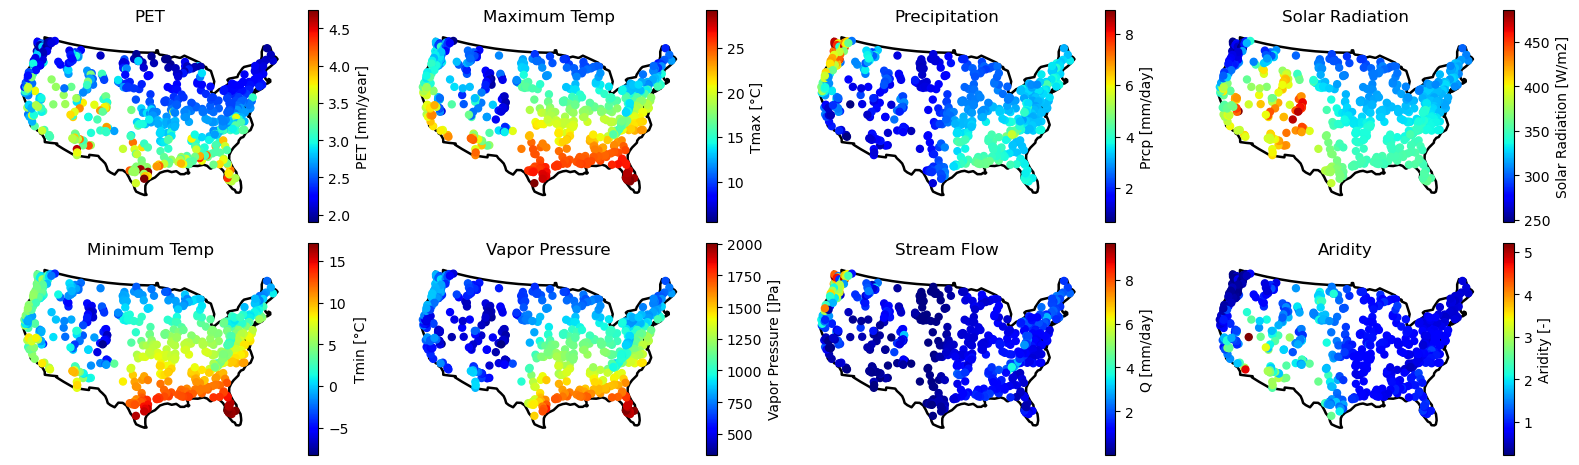

In [49]:
conus = gpd.GeoSeries(conus_geom, crs=world.crs).to_crs(5070)
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 5), facecolor="w", sharex=True, sharey=True)
# Plotting 'p_mean'
conus.plot(ax=ax[0, 0], facecolor="none", edgecolor="k", linewidth=1.8)
attrs.to_crs(5070).plot(ax=ax[0, 0], column="pet_mean", legend=True, cmap="jet", legend_kwds={'label': "PET [mm/year]"}, markersize=25)
ax[0, 0].set_title('PET')

# Plotting 'tmax(C)'
conus.plot(ax=ax[0, 1], facecolor="none", edgecolor="k", linewidth=1.8)
attrs.to_crs(5070).plot(ax=ax[0, 1], column="tmax(C)", legend=True, cmap="jet", legend_kwds={'label': "Tmax [°C]"}, markersize=25)
ax[0, 1].set_title('Maximum Temp')

# Plotting 'prcp(mm/day)'
conus.plot(ax=ax[0, 2], facecolor="none", edgecolor="k", linewidth=1.8)
attrs.to_crs(5070).plot(ax=ax[0, 2], column="prcp(mm/day)", legend=True, cmap="jet", legend_kwds={'label': "Prcp [mm/day]"}, markersize=25)
ax[0, 2].set_title('Precipitation')

# Plotting 'srad(W/m2)'
conus.plot(ax=ax[0, 3], facecolor="none", edgecolor="k", linewidth=1.8)
attrs.to_crs(5070).plot(ax=ax[0, 3], column="srad(W/m2)", legend=True, cmap="jet", legend_kwds={'label': "Solar Radiation [W/m2]"}, markersize=25)
ax[0, 3].set_title('Solar Radiation')

# Plotting 'tmin(C)'
conus.plot(ax=ax[1, 0], facecolor="none", edgecolor="k", linewidth=1.8)
attrs.to_crs(5070).plot(ax=ax[1, 0], column="tmin(C)", legend=True, cmap="jet", legend_kwds={'label': "Tmin [°C]"}, markersize=25)
ax[1, 0].set_title('Minimum Temp')

# Plotting 'vp(Pa)'
conus.plot(ax=ax[1, 1], facecolor="none", edgecolor="k", linewidth=1.8)
attrs.to_crs(5070).plot(ax=ax[1, 1], column="vp(Pa)", legend=True, cmap="jet", legend_kwds={'label': "Vapor Pressure []Pa]"}, markersize=25)
ax[1, 1].set_title('Vapor Pressure')

# Plotting 'q_mean'
conus.plot(ax=ax[1, 2], facecolor="none", edgecolor="k", linewidth=1.8)
attrs.to_crs(5070).plot(ax=ax[1, 2], column="q_mean", legend=True, cmap="jet", legend_kwds={'label': "Q [mm/day]"}, markersize=25)
ax[1, 2].set_title('Stream Flow')

# Plotting 'aridity'
conus.plot(ax=ax[1, 3], facecolor="none", edgecolor="k", linewidth=1.8)
attrs.to_crs(5070).plot(ax=ax[1, 3], column="aridity", legend=True, cmap="jet", legend_kwds={'label': "Aridity [-]"}, markersize=25)
ax[1, 3].set_title('Aridity')

for axes in ax.flat:
    axes.set_axis_off()

fig.tight_layout()
fig.subplots_adjust(top=0.92)

# Save the plot
fig.savefig(Path("CAMELS_Daymet_longTerm_variables.png"))

## 2) Running LSTM on single basin

In [50]:
import torch
torch.cuda.is_available()

True

In [51]:
from pathlib import Path
from typing import Tuple, List

import gcsfs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import tqdm


FILE_SYSTEM = gcsfs.core.GCSFileSystem(requester_pays=True)
CAMELS_ROOT = Path('/mh1/Atakallou/MLproject/basin_dataset_public_v1p2')
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

In [52]:
DEVICE

device(type='cuda', index=0)

In [53]:
import glob
import os
def load_forcing(basin: str) -> Tuple[pd.DataFrame, int]:
    
    forcing_path ='/mh1/Atakallou/MLproject/basin_dataset_public_v1p2/basin_mean_forcing/daymet'
    pattern = os.path.join(forcing_path, '**', f'{basin}_*.txt')
    files = glob.glob(pattern, recursive=True)

    if not files:
        raise RuntimeError(f'No forcing file found for Basin {basin}')
    else:
        file_path = files[0]  # Use the first file found
        print(f"Using file path: {file_path}")
    
    with open(file_path,'r') as fp:
        df = pd.read_csv(fp, sep='\s+', header=3)
    dates = (df.Year.map(str) + "/" + df.Mnth.map(str) + "/"
             + df.Day.map(str))
    df.index = pd.to_datetime(dates, format="%Y/%m/%d")

    # load area from header
    with open(file_path,'r') as fp:
        content = fp.readlines()
        area = int(content[2])

    return df, area


def load_discharge(basin: str, area: int) ->  pd.Series:
    
    discharge_path = '/mh1/Atakallou/MLproject/basin_dataset_public_v1p2/usgs_streamflow'
    
    pattern = os.path.join(discharge_path, '**', f'{basin}_*.txt')
    files = glob.glob(pattern, recursive=True)

    if not files:
        raise RuntimeError(f'No Discharge file found for Basin {basin}')
    else:
        file_path = files[0]  # Use the first file found
        print(f"Using file path: {file_path}")    
    
    col_names = ['basin', 'Year', 'Mnth', 'Day', 'QObs', 'flag']
    with open(file_path,'r') as fp:
        df = pd.read_csv(fp, sep='\s+', header=None, names=col_names)
    dates = (df.Year.map(str) + "/" + df.Mnth.map(str) + "/"
             + df.Day.map(str))
    df.index = pd.to_datetime(dates, format="%Y/%m/%d")

    # normalize discharge from cubic feed per second to mm per day
    df.QObs = 28316846.592 * df.QObs * 86400 / (area * 10 ** 6)

    return df.QObs

In [54]:
def reshape_data(x: np.ndarray, y: np.ndarray, seq_length: int) -> Tuple[np.ndarray, np.ndarray]:
    
    num_samples, num_features = x.shape

    x_new = np.zeros((num_samples - seq_length + 1, seq_length, num_features))
    y_new = np.zeros((num_samples - seq_length + 1, 1))

    for i in range(0, x_new.shape[0]):
        x_new[i, :, :num_features] = x[i:i + seq_length, :]
        y_new[i, :] = y[i + seq_length - 1, 0]

    return x_new, y_new

In [55]:
class CamelsTXT(Dataset):
    
    def __init__(self, basin: str, seq_length: int=365,period: str=None,
                 dates: List=None, means: pd.Series=None, stds: pd.Series=None):

        self.basin = basin
        self.seq_length = seq_length
        self.period = period
        self.dates = dates
        self.means = means
        self.stds = stds

        # load data into memory
        self.x, self.y = self._load_data()

        # store number of samples as class attribute
        self.num_samples = self.x.shape[0]

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx: int):
        return self.x[idx], self.y[idx]

    def _load_data(self):
        """Load input and output data from text files."""
        df, area = load_forcing(self.basin)
        df['QObs(mm/d)'] = load_discharge(self.basin, area)
        
        if self.dates is not None:
            # If meteorological observations exist before start date
            # use these as well. Similiar to hydrological warmup period.
            if self.dates[0] - pd.DateOffset(days=self.seq_length) > df.index[0]:
                start_date = self.dates[0] - pd.DateOffset(days=self.seq_length)
            else:
                start_date = self.dates[0]
            df = df[start_date:self.dates[1]]

        # if training period store means and stds
        if self.period == 'train':
            self.means = df.mean()
            self.stds = df.std()

        # extract input and output features from DataFrame
        x = np.array([df['prcp(mm/day)'].values,
                      df['srad(W/m2)'].values,
                      df['tmax(C)'].values,
                      df['tmin(C)'].values,
                      df['vp(Pa)'].values]).T
        y = np.array([df['QObs(mm/d)'].values]).T

        # normalize data, reshape for LSTM training and remove invalid samples
        x = self._local_normalization(x, variable='inputs')
        x, y = reshape_data(x, y, self.seq_length)

        if self.period == "train":
            # Delete all samples, where discharge is NaN
            if np.sum(np.isnan(y)) > 0:
                print(f"Deleted some records because of NaNs {self.basin}")
                x = np.delete(x, np.argwhere(np.isnan(y)), axis=0)
                y = np.delete(y, np.argwhere(np.isnan(y)), axis=0)
            
            # Deletes all records, where no discharge was measured (-999)
            x = np.delete(x, np.argwhere(y < 0)[:, 0], axis=0)
            y = np.delete(y, np.argwhere(y < 0)[:, 0], axis=0)
            
            # normalize discharge
            y = self._local_normalization(y, variable='output')

        # convert arrays to torch tensors
        x = torch.from_numpy(x.astype(np.float32))
        y = torch.from_numpy(y.astype(np.float32))

        return x, y

    def _local_normalization(self, feature: np.ndarray, variable: str) -> \
            np.ndarray:
        
        if variable == 'inputs':
            means = np.array([self.means['prcp(mm/day)'],
                              self.means['srad(W/m2)'],
                              self.means['tmax(C)'],
                              self.means['tmin(C)'],
                              self.means['vp(Pa)']])
            stds = np.array([self.stds['prcp(mm/day)'],
                             self.stds['srad(W/m2)'],
                             self.stds['tmax(C)'],
                             self.stds['tmin(C)'],
                             self.stds['vp(Pa)']])
            feature = (feature - means) / stds
        elif variable == 'output':
            feature = ((feature - self.means["QObs(mm/d)"]) /
                       self.stds["QObs(mm/d)"])
        else:
            raise RuntimeError(f"Unknown variable type {variable}")

        return feature

    def local_rescale(self, feature: np.ndarray, variable: str) -> \
            np.ndarray:

        if variable == 'inputs':
            means = np.array([self.means['prcp(mm/day)'],
                              self.means['srad(W/m2)'],
                              self.means['tmax(C)'],
                              self.means['tmin(C)'],
                              self.means['vp(Pa)']])
            stds = np.array([self.stds['prcp(mm/day)'],
                             self.stds['srad(W/m2)'],
                             self.stds['tmax(C)'],
                             self.stds['tmin(C)'],
                             self.stds['vp(Pa)']])
            feature = feature * stds + means
        elif variable == 'output':
            feature = (feature * self.stds["QObs(mm/d)"] +
                       self.means["QObs(mm/d)"])
        else:
            raise RuntimeError(f"Unknown variable type {variable}")

        return feature

    def get_means(self):
        return self.means

    def get_stds(self):
        return self.stds

In [56]:
class Model(nn.Module):
       
    def __init__(self, hidden_size: int, dropout_rate: float=0.0):

        super(Model, self).__init__()
        self.hidden_size = hidden_size
        self.dropout_rate = dropout_rate
        
        # create required layer
        self.lstm = nn.LSTM(input_size=5, hidden_size=self.hidden_size, 
                            num_layers=1, bias=True, batch_first=True)
        self.dropout = nn.Dropout(p=self.dropout_rate)
        self.fc = nn.Linear(in_features=self.hidden_size, out_features=1)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:

        output, (h_n, c_n) = self.lstm(x)
        
        # perform prediction only at the end of the input sequence
        pred = self.fc(self.dropout(h_n[-1,:,:]))
        return pred

In [57]:
def train_epoch(model, optimizer, loader, loss_func, epoch):

    model.train()
    pbar = tqdm.tqdm_notebook(loader)
    pbar.set_description(f"Epoch {epoch}")
   
    for xs, ys in pbar:
        
        optimizer.zero_grad()
        xs, ys = xs.to(DEVICE), ys.to(DEVICE)

        y_hat = model(xs)
       
        loss = loss_func(y_hat, ys, qstd)
        
        loss.backward()
       
        optimizer.step()
       
        pbar.set_postfix_str(f"Loss: {loss.item():.4f}")

        
def eval_model(model, loader) -> Tuple[torch.Tensor, torch.Tensor]:
    
    # set model to eval mode (important for dropout)
    model.eval()
    obs = []
    preds = []
    # in inference mode, we don't need to store intermediate steps for
    # backprob
    with torch.no_grad():
        # request mini-batch of data from the loader
        for xs, ys in loader:
            # push data to GPU (if available)
            xs = xs.to(DEVICE)
            # get model predictions
            y_hat = model(xs)
            obs.append(ys)
            preds.append(y_hat)
            
    return torch.cat(obs), torch.cat(preds)
        
def calc_nse(obs: np.array, sim: np.array) -> float:
    
    # only consider time steps, where observations are available
    sim = np.delete(sim, np.argwhere(obs < 0), axis=0)
    obs = np.delete(obs, np.argwhere(obs < 0), axis=0)

    # check for NaNs in observations
    sim = np.delete(sim, np.argwhere(np.isnan(obs)), axis=0)
    obs = np.delete(obs, np.argwhere(np.isnan(obs)), axis=0)

    denominator = np.sum((obs - np.mean(obs)) ** 2)
    numerator = np.sum((sim - obs) ** 2)
    nse_val = 1 - numerator / denominator

    return nse_val

In [58]:

def custom(predicted, observed, qstd):
    loss = torch.sum((predicted - observed)**2) / qstd #torch.sum((observed - torch.mean(observed))**2)
    return loss

def mse_loss(observation, prediction):
    prediction_tensor = torch.tensor(prediction, dtype=observation.dtype, device=observation.device)
    mse = torch.mean((observation - prediction_tensor) ** 2)
    return mse.item()
    
def compute_correlation(observation, prediction):
    prediction = torch.from_numpy(prediction).to(observation.device, dtype=observation.dtype)
    obs_mean = torch.mean(observation)
    pred_mean = torch.mean(prediction)
    covariance = torch.mean((observation - obs_mean) * (prediction - pred_mean))
    obs_std = torch.sqrt(torch.mean((observation - obs_mean) ** 2))
    pred_std = torch.sqrt(torch.mean((prediction - pred_mean) ** 2))
    correlation_coefficient = covariance / (obs_std * pred_std)
    return correlation_coefficient.item()
    
def kge(observation, prediction):
    r = compute_correlation(observation, prediction)
    mean_obs = observation.numpy().mean()
    mean_pred = prediction.mean()
    std_obs = observation.numpy().std()
    std_pred = prediction.std()
    std_obs=torch.tensor(std_obs)
    mean_obs=torch.tensor(mean_obs)
    alpha = std_pred / std_obs
    beta = mean_pred / mean_obs
    kge = 1 - torch.sqrt((alpha - 1)**2 + (beta - 1)**2 + (r - 1)**2)
    return kge.item()

In [59]:
basin = '01013500' 
hidden_size = 10 
dropout_rate = 0.0
learning_rate = 1e-3 
sequence_length = 365 

##############
# Data set up#
##############

# Training data
start_date = pd.to_datetime("1980-10-01", format="%Y-%m-%d")
end_date = pd.to_datetime("1995-09-30", format="%Y-%m-%d")
ds_train = CamelsTXT(basin, seq_length=sequence_length, period="train", dates=[start_date, end_date])
tr_loader = DataLoader(ds_train, batch_size=256, shuffle=True)

# Validation data. We use the feature means/stds of the training period for normalization
means = ds_train.get_means()
stds = ds_train.get_stds()
start_date = pd.to_datetime("1995-10-01", format="%Y-%m-%d")
end_date = pd.to_datetime("2000-09-30", format="%Y-%m-%d")
ds_val = CamelsTXT(basin, seq_length=sequence_length, period="eval", dates=[start_date, end_date],
                     means=means, stds=stds)
qstd = ds_val.get_stds()['QObs(mm/d)'] #Compute std of whole observation for normalization
val_loader = DataLoader(ds_val, batch_size=2048, shuffle=False)

# Test data. We use the feature means/stds of the training period for normalization
start_date = pd.to_datetime("2000-10-01", format="%Y-%m-%d")
end_date = pd.to_datetime("2010-09-30", format="%Y-%m-%d")
ds_test = CamelsTXT(basin, seq_length=sequence_length, period="eval", dates=[start_date, end_date],
                     means=means, stds=stds)
test_loader = DataLoader(ds_test, batch_size=2048, shuffle=False)


#########################
# Model, Optimizer, Loss#
#########################

model = Model(hidden_size=hidden_size, dropout_rate=dropout_rate).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_func = custom

Using file path: /mh1/Atakallou/MLproject/basin_dataset_public_v1p2/basin_mean_forcing/daymet/01/01013500_lump_cida_forcing_leap.txt
Using file path: /mh1/Atakallou/MLproject/basin_dataset_public_v1p2/usgs_streamflow/01/01013500_streamflow_qc.txt
Using file path: /mh1/Atakallou/MLproject/basin_dataset_public_v1p2/basin_mean_forcing/daymet/01/01013500_lump_cida_forcing_leap.txt
Using file path: /mh1/Atakallou/MLproject/basin_dataset_public_v1p2/usgs_streamflow/01/01013500_streamflow_qc.txt
Using file path: /mh1/Atakallou/MLproject/basin_dataset_public_v1p2/basin_mean_forcing/daymet/01/01013500_lump_cida_forcing_leap.txt
Using file path: /mh1/Atakallou/MLproject/basin_dataset_public_v1p2/usgs_streamflow/01/01013500_streamflow_qc.txt


In [64]:
n_epochs = 50 # Number of training epochs
dates = pd.date_range(start="1995-10-01", end="2000-10-01", freq='D')
best_KGE = 0
best_NSE = 0
best_MSE = 10000
for i in range(n_epochs):
    train_epoch(model, optimizer, tr_loader, loss_func, i+1)
    obs, preds = eval_model(model, val_loader)
    preds = ds_val.local_rescale(preds.cpu().numpy(), variable='output') #preds = ds_val.local_rescale(preds.numpy(), variable='output')
    nse = calc_nse(obs.numpy(), preds)
    # if nse>best_NSE:
        # best_NSE=nse
    tqdm.tqdm.write(f"Validation NSE: {nse:.2f}")
    MSE = mse_loss(obs, preds)

    tqdm.tqdm.write(f"Validation MSE: {MSE:.2f}")
    kge_value = kge(obs, preds)
    # if kge_value>best_KGE:
        # best_KGE=kge_value
    tqdm.tqdm.write(f"Validation KGE: {kge_value:.2f}")
    # if MSE<best_MSE:
    #     best_MSE=MSE
    #     best_KGE=kge_value
    #     obs_np = obs.numpy().flatten()
    #     preds = preds.flatten()
    #     data = pd.DataFrame({
    #         'Date': dates,
    #         'Observed Streamflow': obs_np,
    #         'Predicted Streamflow': preds})
    #     loss_name="MSE"
    if nse>best_NSE:
        best_NSE=nse
        best_KGE=kge_value
        obs_np = obs.numpy().flatten()
        preds = preds.flatten()
        data = pd.DataFrame({
            'Date': dates,
            'Observed Streamflow': obs_np,
            'Predicted Streamflow': preds})
        loss_name="NSE" 
# tqdm.tqdm.write(f"Best Validation MSE: {best_MSE:.2f}")        
tqdm.tqdm.write(f"Best Validation NSE: {best_NSE:.2f}")
tqdm.tqdm.write(f"Best Validation KGE: {best_KGE:.2f}")
# Set the Date column as the index (optional)
data.set_index('Date', inplace=True)

# Save the DataFrame to a CSV file
#csv_file_path = f'/mh1/Atakallou/MLproject/output/{loss_name}_{basin}_streamflow_data.csv'
#data.to_csv(csv_file_path)

/tmp/ipykernel_61684/2138761174.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm.tqdm_notebook(loader)


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.02
Validation MSE: 4.22
Validation KGE: -0.25


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.07
Validation MSE: 3.99
Validation KGE: -0.10


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.13
Validation MSE: 3.74
Validation KGE: 0.01


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.21
Validation MSE: 3.39
Validation KGE: 0.12


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.31
Validation MSE: 2.96
Validation KGE: 0.23


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.44
Validation MSE: 2.42
Validation KGE: 0.35


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.56
Validation MSE: 1.90
Validation KGE: 0.47


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.65
Validation MSE: 1.49
Validation KGE: 0.55


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.72
Validation MSE: 1.21
Validation KGE: 0.64


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.75
Validation MSE: 1.06
Validation KGE: 0.71


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.78
Validation MSE: 0.95
Validation KGE: 0.76


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.79
Validation MSE: 0.88
Validation KGE: 0.78


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.81
Validation MSE: 0.82
Validation KGE: 0.81


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.82
Validation MSE: 0.77
Validation KGE: 0.83


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.83
Validation MSE: 0.74
Validation KGE: 0.84


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.83
Validation MSE: 0.72
Validation KGE: 0.86


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.85
Validation MSE: 0.65
Validation KGE: 0.86


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.86
Validation MSE: 0.62
Validation KGE: 0.87


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.85
Validation MSE: 0.63
Validation KGE: 0.88


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.86
Validation MSE: 0.59
Validation KGE: 0.88


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.87
Validation MSE: 0.56
Validation KGE: 0.90


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.87
Validation MSE: 0.55
Validation KGE: 0.90


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.88
Validation MSE: 0.53
Validation KGE: 0.90


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.88
Validation MSE: 0.52
Validation KGE: 0.90


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.88
Validation MSE: 0.51
Validation KGE: 0.91


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.87
Validation MSE: 0.57
Validation KGE: 0.92


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.88
Validation MSE: 0.50
Validation KGE: 0.93


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.88
Validation MSE: 0.53
Validation KGE: 0.92


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.88
Validation MSE: 0.51
Validation KGE: 0.92


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.86
Validation MSE: 0.62
Validation KGE: 0.90


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.86
Validation MSE: 0.59
Validation KGE: 0.92


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.88
Validation MSE: 0.52
Validation KGE: 0.93


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.88
Validation MSE: 0.52
Validation KGE: 0.93


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.88
Validation MSE: 0.53
Validation KGE: 0.93


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.87
Validation MSE: 0.54
Validation KGE: 0.92


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.87
Validation MSE: 0.57
Validation KGE: 0.92


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.88
Validation MSE: 0.53
Validation KGE: 0.93


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.86
Validation MSE: 0.59
Validation KGE: 0.91


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.87
Validation MSE: 0.56
Validation KGE: 0.93


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.87
Validation MSE: 0.54
Validation KGE: 0.92


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.87
Validation MSE: 0.56
Validation KGE: 0.91


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.88
Validation MSE: 0.53
Validation KGE: 0.93


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.86
Validation MSE: 0.58
Validation KGE: 0.91


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.86
Validation MSE: 0.59
Validation KGE: 0.90


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.85
Validation MSE: 0.64
Validation KGE: 0.89


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.86
Validation MSE: 0.58
Validation KGE: 0.92


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.87
Validation MSE: 0.56
Validation KGE: 0.90


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.86
Validation MSE: 0.60
Validation KGE: 0.90


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.86
Validation MSE: 0.59
Validation KGE: 0.91


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.86
Validation MSE: 0.58
Validation KGE: 0.91
Best Validation NSE: 0.88
Best Validation KGE: 0.93


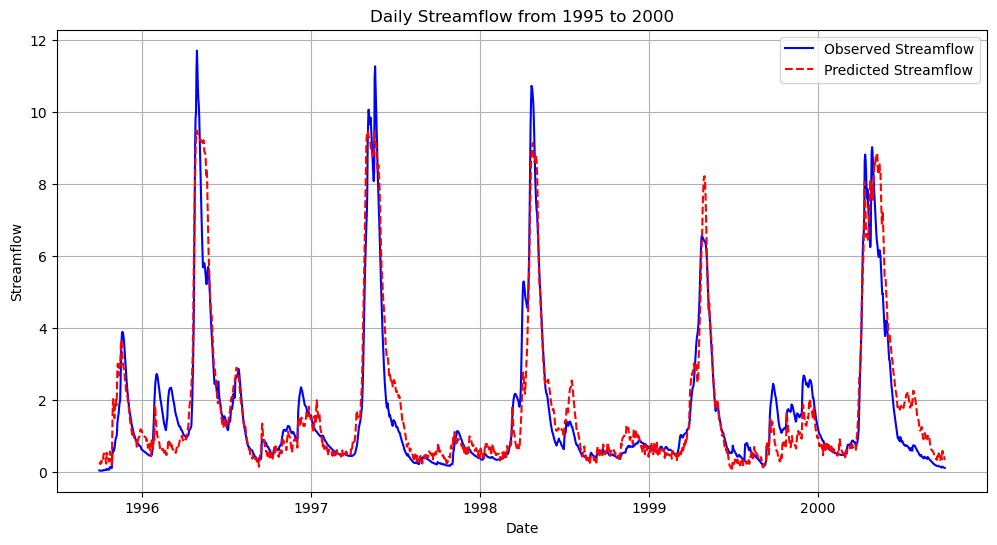

In [28]:
# Convert the tensor to a numpy array if necessary
obs_np = obs.numpy()
# Generate the date range from "1995-10-01" to "2000-09-30"
dates = pd.date_range(start="1995-10-01", end="2000-10-01", freq='D')

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(dates, obs_np, label='Observed Streamflow', color='blue')
plt.plot(dates, preds, label='Predicted Streamflow', color='red', linestyle='--')
plt.title('Daily Streamflow from 1995 to 2000')
plt.xlabel('Date')
plt.ylabel('Streamflow')
plt.legend()
plt.grid(True)
plt.show()

In [65]:
# Convert the tensor to a numpy array if necessary
obs_np = obs.numpy().flatten()
preds = preds.flatten()
# Generate the date range from "1995-10-01" to "2000-09-30"
dates = pd.date_range(start="1995-10-01", end="2000-10-01", freq='D')
# Create a pandas DataFrame with the dates and data
data = pd.DataFrame({
    'Date': dates,
    'Observed Streamflow': obs_np,
    'Predicted Streamflow': preds})
# })



In [66]:
data

,Date,Observed Streamflow,Predicted Streamflow
0,1995-10-01,0.053043,0.254234
1,1995-10-02,0.051961,0.219718
2,1995-10-03,0.049796,0.203129
3,1995-10-04,0.046548,0.243794
4,1995-10-05,0.045465,0.303569
...,...,...,...
1823,2000-09-27,0.149387,0.457729
1824,2000-09-28,0.141809,0.426280
1825,2000-09-29,0.128819,0.451195
1826,2000-09-30,0.122324,0.491187


## 3) Create KGE loss function in Pytorch

In [67]:
def local_normalization(feature, variable, means, stds):
        """Normalize input/output features with local mean/std.

        :param feature: Numpy array containing the feature(s) as matrix.
        :param variable: Either 'inputs' or 'output' showing which feature will
            be normalized
        :return: array containing the normalized feature
        """
        if variable == 'inputs':
            means = np.array([means['prcp(mm/day)'],
                              means['srad(W/m2)'],
                              means['tmax(C)'],
                              means['tmin(C)'],
                              means['vp(Pa)']])
            stds = np.array([stds['prcp(mm/day)'],
                             stds['srad(W/m2)'],
                             stds['tmax(C)'],
                             stds['tmin(C)'],
                             stds['vp(Pa)']])
            feature = (feature - means) / stds
        elif variable == 'output':
            feature = ((feature - means["QObs(mm/d)"]) /
                       stds["QObs(mm/d)"])
        else:
            raise RuntimeError(f"Unknown variable type {variable}")

        return feature



def reshape_data(x: np.ndarray, y: np.ndarray, seq_length: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Reshape matrix data into sample shape for LSTM training.

    :param x: Matrix containing input features column wise and time steps row wise
    :param y: Matrix containing the output feature.
    :param seq_length: Length of look back days for one day of prediction
    
    :return: Two np.ndarrays, the first of shape (samples, length of sequence,
        number of features), containing the input data for the LSTM. The second
        of shape (samples, 1) containing the expected output for each input
        sample.
    """
    num_samples, num_features = x.shape

    x_new = np.zeros((num_samples - seq_length + 1, seq_length, num_features))
    y_new = np.zeros((num_samples - seq_length + 1, 1))

    for i in range(0, x_new.shape[0]):
        x_new[i, :, :num_features] = x[i:i + seq_length, :]
        y_new[i, :] = y[i + seq_length - 1, 0]

    return x_new, y_new

---------------------------------------------------------   Until Apr 16 ---------------------------------------------------------

## 4) Multi-basin training

## 5) Validation on pseudo-ungauged basins